# Sandbox for simulating and predicting a bivariate Guassian random field

NOTE: there is no model fitting in this analysis; prediction is carried out using the true model

Findings:
- if measurement error is too large (> ~5% of process variance), kriging does better in terms of MSPE and MAPE
- in cases where we are "data rich" (even just 10% of the process is sampled), it's tough for cokriging to provide much (if any) advantage in prediction accuracy (still helps with uncertainty)
  - this might have the most impact on the improvement offered by cokriging
- if the prediction window is too small, kriging might do better
  - to a point, larger prediction windows lead to better results for cokriging -- but the sweet spot may actually be on the smaller side; remember kriging is a local operation

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../src")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from cmcrameri import cm

import model
import sim
import prediction
import plot

%matplotlib inline

In [3]:
# Notebook configuration

# Simulation
seed = 1
param_vals = [1.0, 1.0, 1.5, 1.5, 1.5, 0.2, 0.2, 0.2, 0.0, 0.0, -0.6]
grid_size = 51
# samp_frac = 0.1 # alternatively, use samp_size = N
samp_size = 100
meas_err = 0.01 # sampling "measurement" error

# Prediction
max_dist = 0.25


In [4]:
true_params = model.MaternParams().set_values(param_vals)
true_params.set_bounds(len_scale = (1e-8, 1.5))
true_mod = model.MultivariateMatern(params=true_params)
true_mod.params.to_dataframe()

,name,value,bounds
0,sigma_11,1.0,"(0.4, 3.5)"
1,sigma_22,1.0,"(0.4, 3.5)"
2,nu_11,1.5,"(0.2, 3.5)"
3,nu_12,1.5,"(0.2, 3.5)"
4,nu_22,1.5,"(0.2, 3.5)"
5,len_scale_11,0.2,"(1e-08, 1.5)"
6,len_scale_12,0.2,"(1e-08, 1.5)"
7,len_scale_22,0.2,"(1e-08, 1.5)"
8,nugget_11,0.0,"(0.0, 0.2)"
9,nugget_22,0.0,"(0.0, 0.2)"


In [5]:
grid = sim.CartesianGrid(xcount=grid_size, ycount=grid_size)
rf = sim.BivariateRandomField(true_mod, grid, seed=seed)
try:
    samples = rf.sample(frac=samp_frac, epsilon=np.sqrt(meas_err))
except:
    samples = rf.sample(size=samp_size, epsilon=np.sqrt(meas_err))
print(f"Sample size: {len(samples[0])}")

Sample size: 100


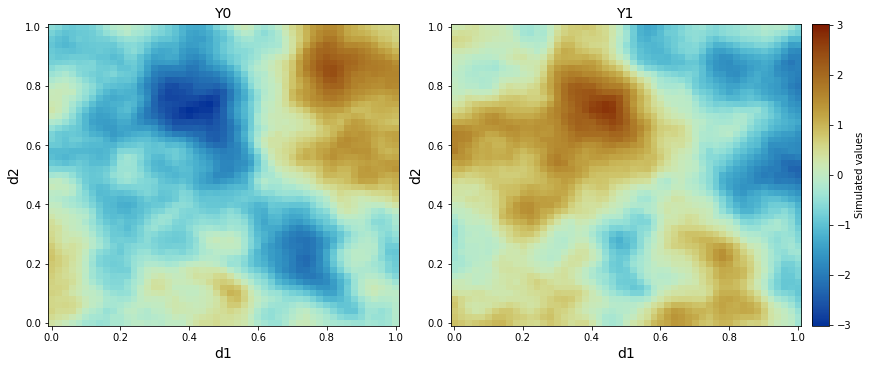

In [6]:
ds_full_fields = rf.to_xarray()
plot.plot_samples(ds_full_fields, fontsize=14)

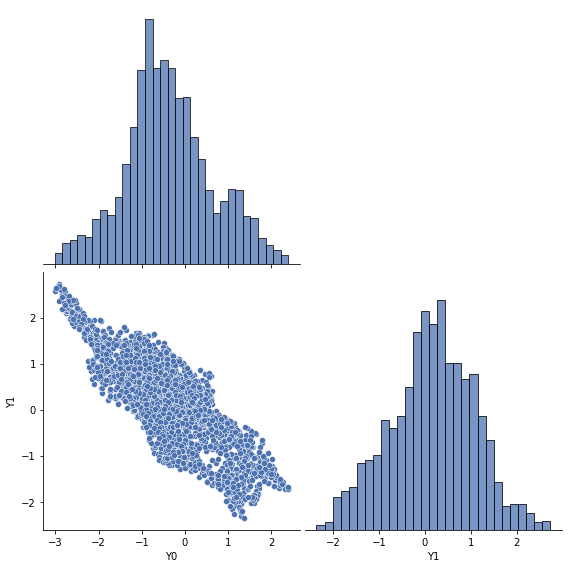

In [7]:
for i, df in enumerate(rf.fields):
    df.rename(columns={"value": f"Y{i}"}, inplace=True)

df_full_fields = pd.merge(*rf.fields, how="outer")
sns.pairplot(df_full_fields, vars=["Y0", "Y1"], corner=True, height=4)

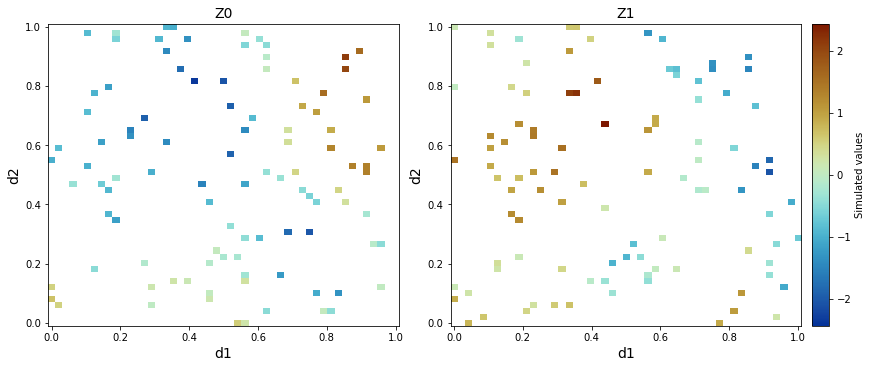

In [8]:
ds_samp = rf.to_xarray(samples)
plot.plot_samples(ds_samp, fontsize=14)

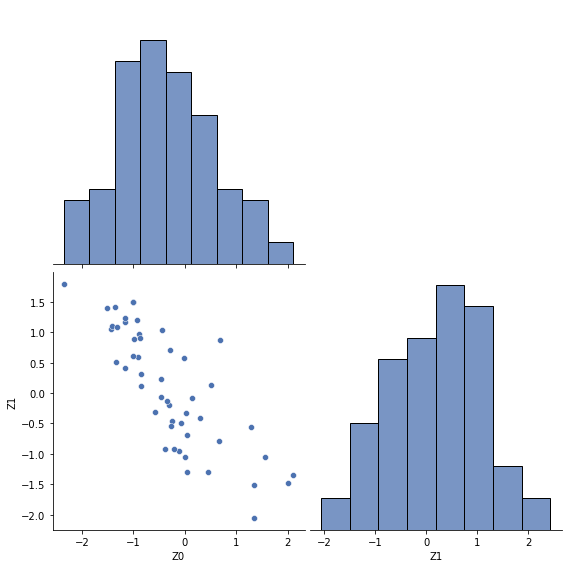

In [9]:
df_full_samp = pd.merge(*samples, how="outer")
sns.pairplot(df_full_samp, vars=["Z0", "Z1"], corner=True, height=4)

## Multivariate Prediction
---

In [10]:
pcoords = grid.coords
mf = rf.to_fields(samples)
cokrig = prediction.Predictor(true_mod, mf, fast_dist=False, dist_units=None)
ds_cokrig = cokrig(1, pcoords, max_dist=max_dist, postprocess=False)
ds_cokrig

/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:237: UserWarning: Invalid model at prediction location [0.   0.08]. This can happen at data locations.
  warnings.warn(
/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:237: UserWarning: Invalid model at prediction location [0.   0.12]. This can happen at data locations.
  warnings.warn(
/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:216: RuntimeWarning: invalid value encountered in sqrt
  pred_std = np.sqrt(c0 - np.matmul(cov_weights, local_pred_cov))
/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:237: UserWarning: Invalid model at prediction location [0.   0.56]. This can happen at data locations.
  warnings.warn(
/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:237: UserWarning: Invalid model at prediction location [0.  0.8]. This can happen at data locations.
  warnings.warn(
/Users/joshjacobson/Projec

<xarray.Dataset>
Dimensions:   (x: 51, y: 51)
Coordinates:
  * x         (x) float64 0.0 0.02 0.04 0.06 0.08 ... 0.92 0.94 0.96 0.98 1.0
  * y         (y) float64 0.0 0.02 0.04 0.06 0.08 ... 0.92 0.94 0.96 0.98 1.0
Data variables:
    pred      (x, y) float64 1.024 1.127 1.174 1.104 ... -0.3973 -0.3554 -0.3185
    pred_err  (x, y) float64 0.2072 0.1825 0.1495 ... 0.7136 0.7361 0.7626

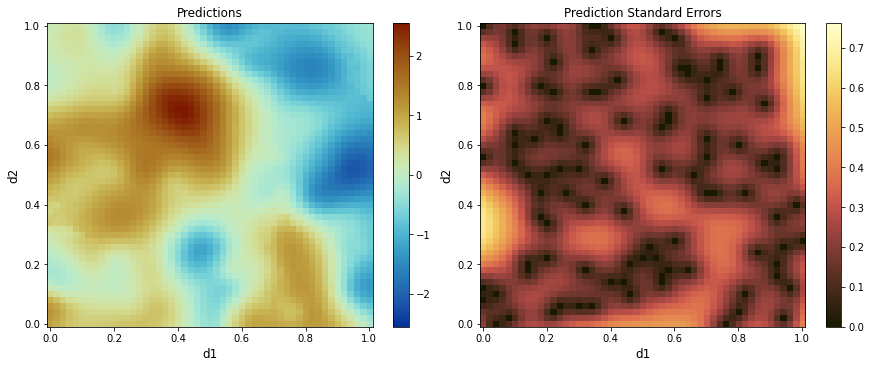

In [11]:
plot.plot_sim_pred(ds_cokrig)

In [12]:
df_cokrig = (
    ds_cokrig.to_dataframe()
    .reset_index()
    .dropna(subset=["pred"])
    .merge(samples[1], on=["x", "y"], how="right")
)
df_cokrig["diff"] = df_cokrig["Z1"] - df_cokrig["pred"]
df_cokrig[["diff", "pred_err"]].describe()

,diff,pred_err
count,1.000000e+02,1.000000e+02
mean,-6.504346e-17,4.088573e-09
std,1.532546e-15,5.597904e-09
min,-5.356826e-15,0.000000e+00
25%,-4.440892e-16,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,4.440892e-16,1.053671e-08
max,6.938894e-15,1.825012e-08


## Univariate Prediction
---

In [13]:
bi_vals = true_mod.params.get_values()[[1, 4, 7, 9]]
tmod_uni = model.MultivariateMatern(n_procs=1)
tmod_uni.params.set_values(bi_vals)
tmod_uni.params.set_bounds(len_scale = (1e-2, 4))
tmod_uni.params.to_dataframe()

,name,value,bounds
0,sigma_11,1.0,"(0.4, 3.5)"
1,nu_11,1.5,"(0.2, 3.5)"
2,len_scale_11,0.2,"(0.01, 4)"
3,nugget_11,0.0,"(0.0, 0.2)"


In [14]:
pcoords = grid.coords
mf = rf.to_fields(samples, i=1)
krig = prediction.Predictor(tmod_uni, mf, fast_dist=False, dist_units=None)
ds_krig = krig(0, pcoords, max_dist=max_dist, postprocess=False)
ds_krig

/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:237: UserWarning: Invalid model at prediction location [0.   0.08]. This can happen at data locations.
  warnings.warn(
/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:237: UserWarning: Invalid model at prediction location [0.   0.12]. This can happen at data locations.
  warnings.warn(
/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:237: UserWarning: Invalid model at prediction location [0.   0.56]. This can happen at data locations.
  warnings.warn(
/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:237: UserWarning: Invalid model at prediction location [0.  0.8]. This can happen at data locations.
  warnings.warn(
/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:237: UserWarning: Invalid model at prediction location [0. 1.]. This can happen at data locations.
  warnings.warn(
/Users/joshjacobson/Projects/si

<xarray.Dataset>
Dimensions:   (x: 51, y: 51)
Coordinates:
  * x         (x) float64 0.0 0.02 0.04 0.06 0.08 ... 0.92 0.94 0.96 0.98 1.0
  * y         (y) float64 0.0 0.02 0.04 0.06 0.08 ... 0.92 0.94 0.96 0.98 1.0
Data variables:
    pred      (x, y) float64 1.013 1.089 1.122 1.067 ... -0.7783 -0.7226 -0.6657
    pred_err  (x, y) float64 0.2073 0.1839 0.1526 ... 0.7787 0.7951 0.8141

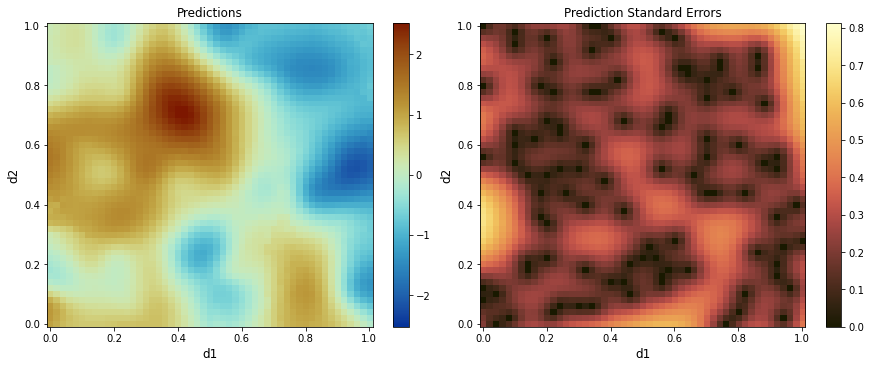

In [15]:
plot.plot_sim_pred(ds_krig)

In [16]:
df_krig = (
    ds_krig.to_dataframe()
    .reset_index()
    .dropna(subset=["pred"])
    .merge(samples[1], on=["x", "y"], how="right")
)
df_krig["diff"] = df_krig["Z1"] - df_krig["pred"]
df_krig[["diff", "pred_err"]].describe()

,diff,pred_err
count,1.000000e+02,1.000000e+02
mean,-1.217342e-16,4.340285e-09
std,6.097922e-16,5.993503e-09
min,-3.164136e-15,0.000000e+00
25%,-2.220446e-16,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,2.220446e-16,1.053671e-08
max,9.436896e-16,1.825012e-08


## Uncertainty Comparison
---

In [17]:
df_cokrig_err = (
    ds_cokrig["pred_err"].to_dataframe().reset_index().dropna()
)
df_krig_err = (
    ds_krig["pred_err"].to_dataframe().reset_index().dropna()
)
df_err_ratio = pd.merge(
    df_cokrig_err,
    df_krig_err,
    on=["x", "y"],
    how="outer",
    suffixes=["_cokrig", "_krig"],
)
df_err_ratio["ratio"] = (df_err_ratio["pred_err_cokrig"]**2) / (df_err_ratio["pred_err_krig"]**2)
df_err_ratio["ratio"][df_err_ratio["ratio"] == 0.0] = np.nan
with pd.option_context("mode.use_inf_as_null", True):
    df_err_ratio.fillna(1, inplace=True)

da_err_ratio = df_err_ratio.set_index(["x", "y"]).to_xarray()["ratio"]

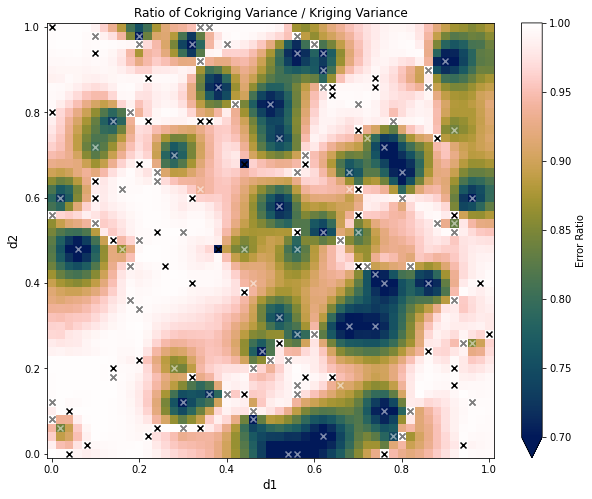

In [18]:
title = "Ratio of Cokriging Variance / Kriging Variance"
# plot.plot_err_ratio(da_err_ratio, loc1=samples[1], loc2=samples[0], title=title)
plot.plot_err_ratio(da_err_ratio, loc1=samples[1], loc2=samples[0], robust=True, title=title)

## Model Validation
---
Clarification: when doing LOOCV for cokriging, if a data point shows up at the same location in multiple datasets, it should only be "removed" from the dataset which is being predicted correct?

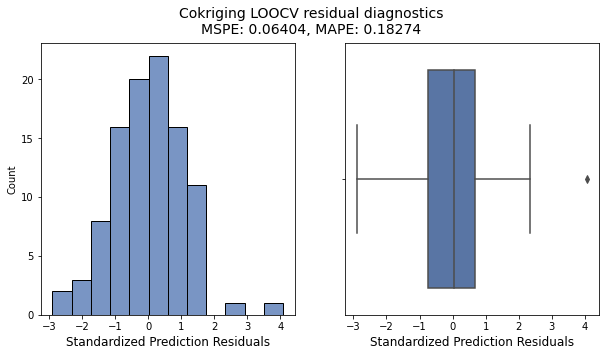

In [19]:
df_cv_cokrig = cokrig.cross_validation(1, max_dist=max_dist, postprocess=False)
plot.plot_cv_resid(df_cv_cokrig, method="Cokriging")

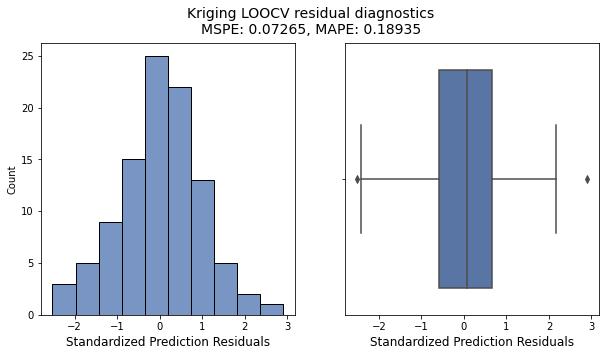

In [20]:
df_cv_krig = krig.cross_validation(0, max_dist=max_dist, postprocess=False)
plot.plot_cv_resid(df_cv_krig, method="Kriging")